# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt
import pandas as pd
import shap
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Reading data and pre-processing

In [3]:
def read_data(file_name):
    # loading csv
    df = pd.read_csv(file_name)
    
    # removing unnamed columns
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    return df

In [4]:
# loading csv
df_general = read_data('predictions/train_predictions_general.csv')

df_gk = read_data('predictions/train_predictions_gk.csv')
df_def = read_data('predictions/train_predictions_def.csv')
df_mid = read_data('predictions/train_predictions_mid.csv')
df_fwd = read_data('predictions/train_predictions_fwd.csv')

In [5]:
df_fwd["Name"].unique()

array(['Che-Adams', 'Julian-Alvarez', 'Michail-Antonio', 'Adam-Armstrong',
       'Taiwo-Awoniyi', 'Patson-Daka', 'Emmanuel-Dennis',
       'Odsonne-Edouard', 'Joe-Gelhardt', 'Sam-Greenwood',
       'Erling-Haaland', 'Kai-Havertz', 'Kelechi-Iheanacho', 'Danny-Ings',
       'Brennan-Johnson', 'Harry-Kane', 'Sekou-Mara',
       'Jean-Philippe-Mateta', 'Neal-Maupay', 'Bryan-Mbeumo',
       'Aleksandar-Mitrovic', 'Kieffer-Moore', 'Eddie-Nketiah',
       'Gianluca-Scamacca', 'Dominic-Solanke', 'Sam-Surridge',
       'Ivan-Toney', 'Deniz-Undav', 'Jamie-Vardy', 'Carlos-Vinicius',
       'Ollie-Watkins', 'Danny-Welbeck', 'Callum-Wilson', 'Chris-Wood'],
      dtype=object)

In [6]:
# df.columns

In [7]:
# df["Name"].unique()

In [8]:
# dropping NaNs
# df = df.dropna(axis=0)

In [9]:
# df.shape

In [10]:
# df[df["Name"] == "Erling-Haaland"]

In [11]:
# df["GW"].hist()

In [12]:
df_general.iloc[0]

Date                        2022-10-02
Day                                Sun
Comp                    Premier League
Round                      Matchweek 9
Venue                             Home
                             ...      
CSAvgOverall                  0.166667
Team ScoreAvgOverall          1.666667
Opp ScoreAvgOverall           1.666667
FPLAvgOverall                      3.5
Points                            2.79
Name: 0, Length: 65, dtype: object

# Choosing features and splitting data

In [13]:
features = ["Points", "Was Home", "Opp rating", 'ScoreForLast5', 'ScoreAgainstLast5']

# career averages
features += ['MinAvgOverall', 'GlsAvgOverall',
       'AstAvgOverall', 'CrdYAvgOverall', 'CrdRAvgOverall', 'xGAvgOverall',
       'xAGAvgOverall', 'CSAvgOverall', 'Team ScoreAvgOverall',
       'Opp ScoreAvgOverall', 'FPLAvgOverall']

info = ["Name", "GW", "Squad", "Opponent", "Was Home", "Opp rating"]
to_predict = ["Total Points"]

In [14]:
START_GAMEWEEK = 8
GAMEWEEK_TO_PREDICT = 19

In [15]:
def split_data(df, start_gw, gw_to_predict, features, to_predict):
    X_train = df[(df["GW"] >= start_gw) & (df["GW"] <= gw_to_predict - 1)][features]
    y_train = df[(df["GW"] >= start_gw) & (df["GW"] <= gw_to_predict - 1)][to_predict]
    
    X_test = df[df["GW"] == gw_to_predict][features]
    y_test = df[df["GW"] == gw_to_predict][to_predict]

    return X_train, y_train, X_test, y_test

In [16]:
X_train_general, y_train_general, X_test_general, y_test_general = split_data(df_general, START_GAMEWEEK, GAMEWEEK_TO_PREDICT, features, to_predict)

X_train_gk, y_train_gk, X_test_gk, y_test_gk = split_data(df_gk, START_GAMEWEEK, GAMEWEEK_TO_PREDICT, features, to_predict)
X_train_def, y_train_def, X_test_def, y_test_def = split_data(df_def, START_GAMEWEEK, GAMEWEEK_TO_PREDICT, features, to_predict)
X_train_mid, y_train_mid, X_test_mid, y_test_mid = split_data(df_mid, START_GAMEWEEK, GAMEWEEK_TO_PREDICT, features, to_predict)
X_train_fwd, y_train_fwd, X_test_fwd, y_test_fwd = split_data(df_fwd, START_GAMEWEEK, GAMEWEEK_TO_PREDICT, features, to_predict)

In [17]:
X_train_general.size, y_train_general.size, X_test_general.size, y_test_general.size

(43488, 2718, 2544, 159)

In [18]:
X_train_gk.size, y_train_gk.size, X_test_gk.size, y_test_gk.size

(4064, 254, 336, 21)

In [19]:
X_train_def.size, y_train_def.size, X_test_def.size, y_test_def.size

(14752, 922, 816, 51)

In [20]:
X_train_mid.size, y_train_mid.size, X_test_mid.size, y_test_mid.size

(19808, 1238, 1088, 68)

In [21]:
X_train_fwd.size, y_train_fwd.size, X_test_fwd.size, y_test_fwd.size

(4864, 304, 304, 19)

# Model and training

In [22]:
model_general = xgb.XGBRegressor(random_state=42)

model_gk = xgb.XGBRegressor(random_state=42)
model_def = xgb.XGBRegressor(random_state=42)
model_mid = xgb.XGBRegressor(random_state=42)
model_fwd = xgb.XGBRegressor(random_state=42, n_estimators=5000)

In [23]:
%%time
model_general.fit(X_train_general, y_train_general)

CPU times: total: 1.34 s
Wall time: 251 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [24]:
%%time
model_gk.fit(X_train_gk, y_train_gk)

CPU times: total: 469 ms
Wall time: 78.8 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [25]:
%%time
model_def.fit(X_train_def, y_train_def)

CPU times: total: 688 ms
Wall time: 126 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [26]:
%%time
model_mid.fit(X_train_mid, y_train_mid)

CPU times: total: 844 ms
Wall time: 175 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [27]:
%%time
model_fwd.fit(X_train_fwd, y_train_fwd)

CPU times: total: 10.8 s
Wall time: 2.02 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

# Predicting and calculating metrics

In [28]:
# make predictions on the test data
predictions_general = model_general.predict(X_test_general)

predictions_gk = model_gk.predict(X_test_gk)
predictions_def = model_def.predict(X_test_def)
predictions_mid = model_mid.predict(X_test_mid)
predictions_fwd = model_fwd.predict(X_test_fwd)

In [29]:
def calculate_mae_mse(y_test, predictions, title):
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    
    print("MAE", title, ":", mae)
    print("MSE", title, ":", mse)

In [30]:
calculate_mae_mse(y_test_general, predictions_general, "General")

MAE General : 2.1034634225539066
MSE General : 8.711157706619092


In [31]:
calculate_mae_mse(y_test_gk, predictions_gk, "GK")

MAE GK : 2.5331898300598064
MSE GK : 10.673901743141556


In [32]:
calculate_mae_mse(y_test_def, predictions_def, "DEF")

MAE DEF : 2.3907757499346545
MSE DEF : 11.562776835351155


In [33]:
calculate_mae_mse(y_test_mid, predictions_mid, "MID")

MAE MID : 1.7892248625867069
MSE MID : 5.906543754079036


In [34]:
calculate_mae_mse(y_test_fwd, predictions_fwd, "FWD")

MAE FWD : 2.3024148658702246
MSE FWD : 13.11245218480059


# Predictions - general

In [35]:
# X_test = df[df["GW"] == GAMEWEEK_TO_PREDICT][features]
# y_test = df[df["GW"] == GAMEWEEK_TO_PREDICT][to_predict]

In [36]:
predictions_gk

array([ 2.7520783 ,  5.1303873 , -0.0737338 ,  3.5589972 ,  4.9626923 ,
        0.16239005,  4.1905246 ,  1.3115693 ,  2.5649452 ,  0.46464905,
        3.9962206 ,  2.443533  ,  4.0483775 ,  5.2619047 ,  3.6794457 ,
        4.604358  ,  3.2717066 , -0.02232287,  1.5904725 ,  6.7112947 ,
        3.652377  ], dtype=float32)

In [37]:
df_predictions_general = df_general[df_general["GW"] == GAMEWEEK_TO_PREDICT]

df_predictions_gk = df_gk[df_gk["GW"] == GAMEWEEK_TO_PREDICT]
df_predictions_def = df_def[df_def["GW"] == GAMEWEEK_TO_PREDICT]
df_predictions_mid = df_mid[df_mid["GW"] == GAMEWEEK_TO_PREDICT]
df_predictions_fwd = df_fwd[df_fwd["GW"] == GAMEWEEK_TO_PREDICT]

In [38]:
df_predictions_general.shape, df_predictions_gk.shape, df_predictions_def.shape, df_predictions_mid.shape, df_predictions_fwd.shape

((159, 65), (21, 65), (51, 65), (68, 65), (19, 65))

In [39]:
len(predictions_general), len(predictions_gk), len(predictions_def), len(predictions_mid), len(predictions_fwd)

(159, 21, 51, 68, 19)

In [40]:
df_predictions_general["pred"] = predictions_general

df_predictions_gk["pred"] = predictions_gk
df_predictions_def["pred"] = predictions_def
df_predictions_mid["pred"] = predictions_mid
df_predictions_fwd["pred"] = predictions_fwd


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [41]:
# model.predict(df[df["GW"] == GAMEWEEK_TO_PREDICT][df["Name"] == "Mohamed-Salah"][features])

In [42]:
df_predictions_general[info + to_predict + ["pred"]].sort_values(by=["pred"], ascending = False).head(20)

,Name,GW,Squad,Opponent,Was Home,Opp rating,Total Points,pred
2612,Kieran-Trippier,19,Newcastle Utd,Arsenal,0.0,1934.447754,8.0,9.433966
1162,Erling-Haaland,19,Manchester City,Chelsea,0.0,1879.017578,2.0,9.117585
1700,Martinelli,19,Arsenal,Newcastle Utd,1.0,1850.296631,3.0,9.049680
1874,Aleksandar-Mitrovic,19,Fulham,Leicester City,0.0,1770.339966,5.0,9.026083
2159,Marcus-Rashford,19,Manchester Utd,Bournemouth,1.0,1647.227417,8.0,7.997180
1036,Morgan-Gibbs-White,19,Nott'ham Forest,Southampton,0.0,1658.088989,3.0,7.551088
1400,Harry-Kane,19,Tottenham,Crystal Palace,0.0,1753.953369,16.0,7.069242
1719,Lisandro-Martinez,19,Manchester Utd,Bournemouth,1.0,1647.227417,1.0,6.809767
2204,Declan-Rice,19,West Ham,Leeds United,0.0,1712.961670,2.0,6.702789
2281,Bukayo-Saka,19,Arsenal,Newcastle Utd,1.0,1850.296631,3.0,6.623152


In [43]:
df_predictions_gk[info + to_predict + ["pred"]].sort_values(by=["pred"], ascending = False).head(20)

,Name,GW,Squad,Opponent,Was Home,Opp rating,Total Points,pred
268,Mark-Travers,19,Bournemouth,Manchester Utd,0.0,1859.299194,2.0,6.711295
182,Robin-Olsen,19,Aston Villa,Wolves,1.0,1686.353516,0.0,5.261905
39,Gavin-Bazunu,19,Southampton,Nott'ham Forest,1.0,1630.994873,2.0,5.130387
72,Lukasz-Fabianski,19,West Ham,Leeds United,0.0,1712.961670,2.0,4.962692
213,Aaron-Ramsdale,19,Arsenal,Newcastle Utd,1.0,1850.296631,6.0,4.604358
95,David-de-Gea,19,Manchester Utd,Bournemouth,1.0,1647.227417,7.0,4.190525
161,Emiliano-Martinez,19,Aston Villa,Wolves,1.0,1686.353516,2.0,4.048378
138,Bernd-Leno,19,Fulham,Leicester City,0.0,1770.339966,10.0,3.996221
203,Nick-Pope,19,Newcastle Utd,Arsenal,0.0,1934.447754,10.0,3.679446
279,Danny-Ward,19,Leicester City,Fulham,1.0,1705.027588,2.0,3.652377


In [44]:
df_predictions_def[info + to_predict + ["pred"]].sort_values(by=["pred"], ascending = False).head(20)

,Name,GW,Squad,Opponent,Was Home,Opp rating,Total Points,pred
856,Kieran-Trippier,19,Newcastle Utd,Arsenal,0.0,1934.447754,8.0,10.286487
153,Timothy-Castagne,19,Leicester City,Fulham,1.0,1705.027588,1.0,6.645778
545,Lisandro-Martinez,19,Manchester Utd,Bournemouth,1.0,1647.227417,1.0,5.633751
123,Dan-Burn,19,Newcastle Utd,Arsenal,0.0,1934.447754,6.0,5.612498
719,Fabian-Schar,19,Newcastle Utd,Arsenal,0.0,1934.447754,6.0,5.390868
105,Sven-Botman,19,Newcastle Utd,Arsenal,0.0,1934.447754,6.0,5.335058
882,Raphael-Varane,19,Manchester Utd,Bournemouth,1.0,1647.227417,0.0,5.145295
696,Mohammed-Salisu,19,Southampton,Nott'ham Forest,1.0,1630.994873,2.0,4.805652
459,Ezri-Konsa,19,Aston Villa,Wolves,1.0,1686.353516,2.0,4.769382
536,Tyrell-Malacia,19,Manchester Utd,Bournemouth,1.0,1647.227417,0.0,4.292134


In [45]:
df_predictions_mid[info + to_predict + ["pred"]].sort_values(by=["pred"], ascending = False).head(20)

,Name,GW,Squad,Opponent,Was Home,Opp rating,Total Points,pred
837,Martinelli,19,Arsenal,Newcastle Utd,1.0,1850.296631,3.0,10.525563
1068,Marcus-Rashford,19,Manchester Utd,Bournemouth,1.0,1647.227417,8.0,6.866934
400,Christian-Eriksen,19,Manchester Utd,Bournemouth,1.0,1647.227417,6.0,6.852627
176,Emi-Buendia,19,Aston Villa,Wolves,1.0,1686.353516,2.0,5.683209
37,Miguel-Almiron,19,Newcastle Utd,Arsenal,0.0,1934.447754,2.0,5.541848
411,Eberechi-Eze,19,Crystal Palace,Tottenham,1.0,1856.231201,2.0,5.425372
430,Bruno-Fernandes,19,Manchester Utd,Bournemouth,1.0,1647.227417,6.0,5.237029
508,Morgan-Gibbs-White,19,Nott'ham Forest,Southampton,0.0,1658.088989,3.0,5.223311
285,Kevin-De-Bruyne,19,Manchester City,Chelsea,0.0,1879.017578,3.0,5.112587
1247,James-Ward-Prowse,19,Southampton,Nott'ham Forest,1.0,1630.994873,2.0,5.103287


In [46]:
df_predictions_fwd[info + to_predict + ["pred"]].sort_values(by=["pred"], ascending = False).head(20)

,Name,GW,Squad,Opponent,Was Home,Opp rating,Total Points,pred
210,Aleksandar-Mitrovic,19,Fulham,Leicester City,0.0,1770.339966,5.0,6.901571
106,Erling-Haaland,19,Manchester City,Chelsea,0.0,1879.017578,2.0,6.028536
162,Harry-Kane,19,Tottenham,Crystal Palace,0.0,1753.953369,16.0,5.697943
302,Ollie-Watkins,19,Aston Villa,Wolves,1.0,1686.353516,2.0,5.446825
10,Che-Adams,19,Southampton,Nott'ham Forest,1.0,1630.994873,2.0,4.543026
285,Jamie-Vardy,19,Leicester City,Fulham,1.0,1705.027588,2.0,4.341315
151,Brennan-Johnson,19,Nott'ham Forest,Southampton,0.0,1658.088989,4.0,4.025383
140,Danny-Ings,19,Aston Villa,Wolves,1.0,1686.353516,8.0,3.989233
202,Bryan-Mbeumo,19,Brentford,Liverpool,1.0,2006.804077,12.0,3.580384
19,Julian-Alvarez,19,Manchester City,Chelsea,0.0,1879.017578,0.0,3.011484


# Feature importance and influence

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

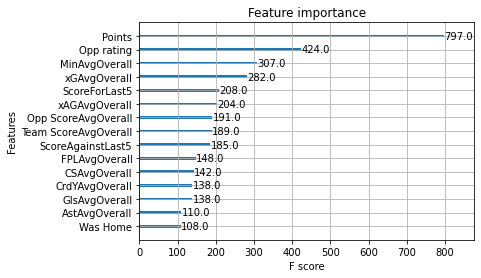

In [47]:
plot_importance(model_fwd)

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


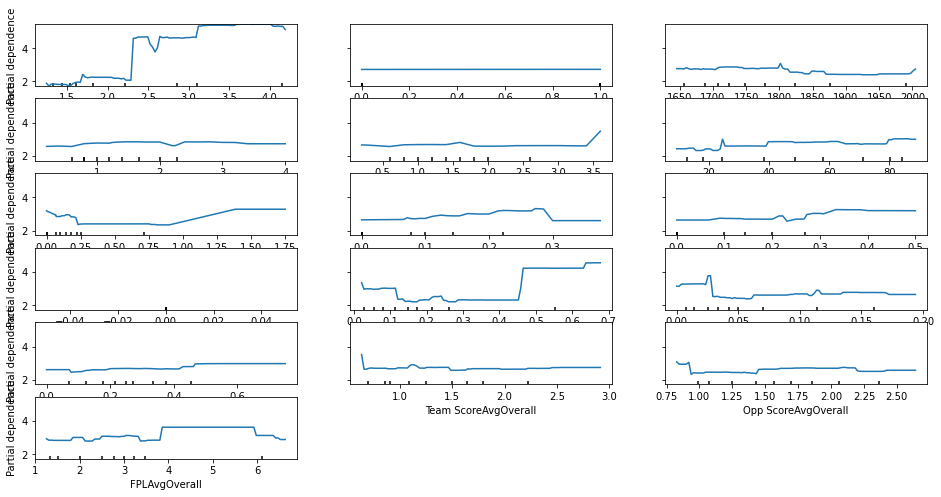

In [48]:
fig, ax = plt.subplots(figsize=(16, 8))
plot_partial_dependence(model_fwd, X_train_fwd, features, ax=ax)

In [49]:
explainer = shap.Explainer(model_fwd, X_train_fwd)
shap_values = explainer(X_train_fwd)

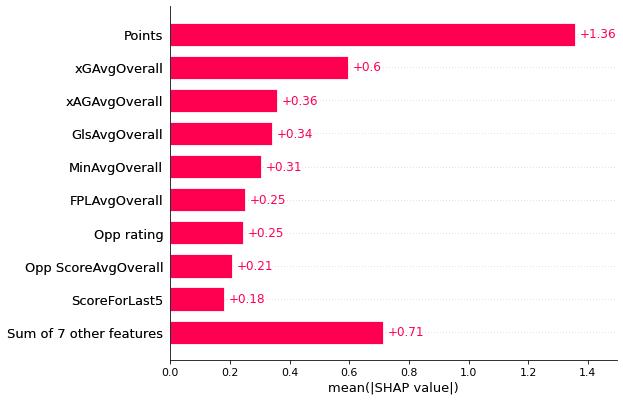

In [50]:
shap.plots.bar(shap_values)

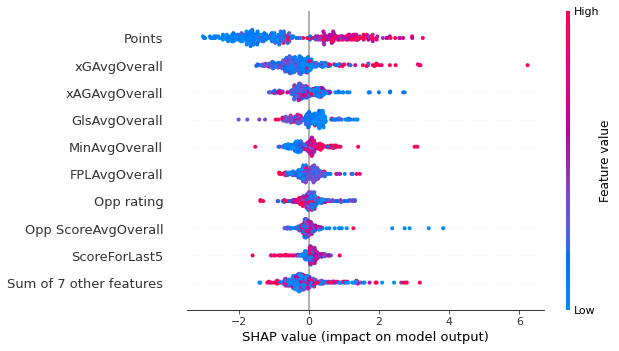

In [51]:
shap.plots.beeswarm(shap_values)

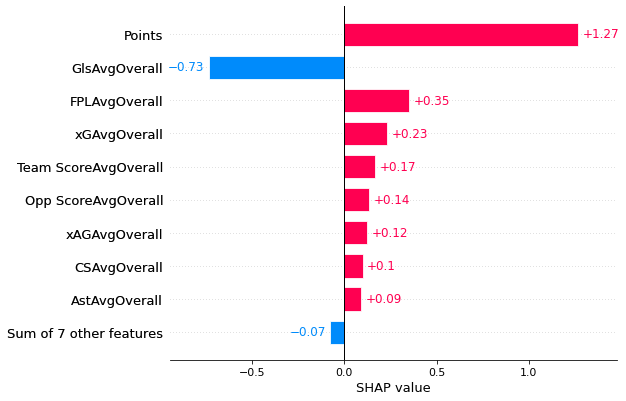

In [52]:
shap.plots.bar(shap_values[0])

In [53]:
df_predictions_fwd[["Name", "FPLAvgOverall"]]

,Name,FPLAvgOverall
10,Che-Adams,3.235294
19,Julian-Alvarez,2.600000
30,Michail-Antonio,2.375000
41,Adam-Armstrong,2.058824
79,Odsonne-Edouard,3.200000
106,Erling-Haaland,9.866667
118,Kai-Havertz,3.500000
129,Kelechi-Iheanacho,1.882353
140,Danny-Ings,3.176471
151,Brennan-Johnson,2.647059


# Saving predictions

In [56]:
df_predictions_general.to_csv("predictions/xgb/xgb_predictions_general.csv")

df_predictions_gk.to_csv("predictions/xgb/xgb_predictions_gk.csv")
df_predictions_def.to_csv("predictions/xgb/xgb_predictions_def.csv")
df_predictions_mid.to_csv("predictions/xgb/xgb_predictions_mid.csv")
df_predictions_fwd.to_csv("predictions/xgb/xgb_predictions_fwd.csv")